In [68]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from sklearn import preprocessing
from xgboost import XGBRegressor
import math
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import datetime
import dateutil.relativedelta
import dateutil
import matplotlib
import matplotlib.pyplot

In [91]:
paths = ["Dataffirm_prep1.html", 
         "Dataffirm_prep2.html", 
         "Dataffirm_prep3.html", 
         "Dataffirm_prep4.html", 
         "Dataffirm_prep5.html", 
         "Dataffirm_prep7.html", 
         "Dataffirm_prep8.html", 
         "Dataffirm_prep9.html", 
         "Dataffirm_prep10.html", 
         "Dataffirm_prep11.html", 
         "Dataffirm_prep12.html", 
         "Dataffirm_prep13.html", 
         "Dataffirm_prep14.html", 
         "Dataffirm_prep15.html", 
         "Dataffirm_prep16.html",
         "Dataffirm_prep17.html",
         "Dataffirm_prep18.html",
         "Dataffirm_prep19.html",
         "Dataffirm_prep20.html",
         "Dataffirm_prep21.html",
         "Dataffirm_prep22.html",
         "Dataffirm_prep23.html",
         "Dataffirm_prep24.html",
         "Dataffirm_prep25.html",
         "Dataffirm_prep26.html",
         "Dataffirm_prep27.html",
         "Dataffirm_prep28.html"]

column_count = 298

rows = np.array([], dtype=np.float).reshape(0,column_count)

def create_rows_and_outputs(path):
    with open(path, "r") as myfile:
        global y_values
        global rows
        s = myfile.read()

        data_x = s[(s.find("<pre>gap here\nbreak ") + 20):s.rfind(",\n</pre>")]
        two_quarters = data_x.split(", gap here\nbreak ")

        new_rows = [row.split(", break ") for row in two_quarters]
        float_rows = [[float(x) for x in row.split(", ")[1:]] for row in new_rows[0]]
        float_rows2 = [[float(x) for x in row.split(", ")[1:]] for row in new_rows[1]]
        rows = np.concatenate((rows, float_rows, float_rows2), axis = 0)

[create_rows_and_outputs(p) for p in paths]
print("rows created")

rows created


In [92]:
rows_shuffled  = np.ndarray.copy(rows)
random.shuffle(rows_shuffled)
rows_dropped_tickers = rows_shuffled[:,1:]

divide_index = len(rows_dropped_tickers)/6
test_arr = rows_dropped_tickers[:divide_index]

x_test = test_arr[:,:-1]
y_test = test_arr[:,-1:]

train_arr = rows_dropped_tickers[divide_index:]

x_train = train_arr[:,:-1]
y_train = train_arr[:,-1:]

In [93]:
model = XGBRegressor(max_depth=10, n_estimators=130, n_jobs=2, tree_method="hist")
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
predictions = [value for value in y_pred]

results = list(zip(predictions, y_test))
accuracy = [math.fabs(float(r[0]) - float(r[1])) for r in results]

print("test average difference: " + str(sum(accuracy)/len(accuracy)))

test average difference: 56169112.631377704


In [94]:
#Actual vs prediction for AAPL:
rows2 = np.array([], dtype=np.float).reshape(0, column_count)

def convert_row_to_floats(row):
    return [float(x) for x in row]

def create_rows_and_outputs_aapl(path):
    with open(path, "r") as myfile:
        global y_values
        global rows2
        s = myfile.read()

        data_x = s[(s.find("<pre>gap here\nbreak ") + 20):s.rfind(",\n</pre>")]
        two_quarters = data_x.split(", gap here\nbreak ")
        new_rows = [row.split(", break ") for row in two_quarters]

        full_rows1 = [row.split(", ") for row in new_rows[0]]
        full_rows2 = [row.split(", ") for row in new_rows[1]]

        aapl_1 = [i[1:] for i in full_rows1 if i[0] == "AAPL"]
        aapl_2 = [i[1:] for i in full_rows2 if i[0] == "AAPL"]

        float_rows1 = [convert_row_to_floats(row) for row in aapl_1]
        float_rows2 = [convert_row_to_floats(row) for row in aapl_2]

        rows2 = np.concatenate((rows2, float_rows1, float_rows2), axis=0)

[create_rows_and_outputs_aapl(p) for p in paths]
print("AAPL only rows created")

AAPL only rows created


In [95]:
rows_aapl = rows2[:,1:]
y_test_aapl = rows_aapl[:,-1:]
x_test_aapl = rows_aapl[:,:-1]

y_pred = model.predict(x_test_aapl)
print(zip(y_pred, y_test_aapl[:,0])[0])

(50552656000.0, 50557000000.0)


In [96]:
start_date = datetime.datetime.strptime("2017-09-30", "%Y-%m-%d")

dates = []

for i in range(54):
    dt = start_date
    dates.append(dt)
    dt = dt - dateutil.relativedelta.relativedelta(months=3)

Populating the interactive namespace from numpy and matplotlib


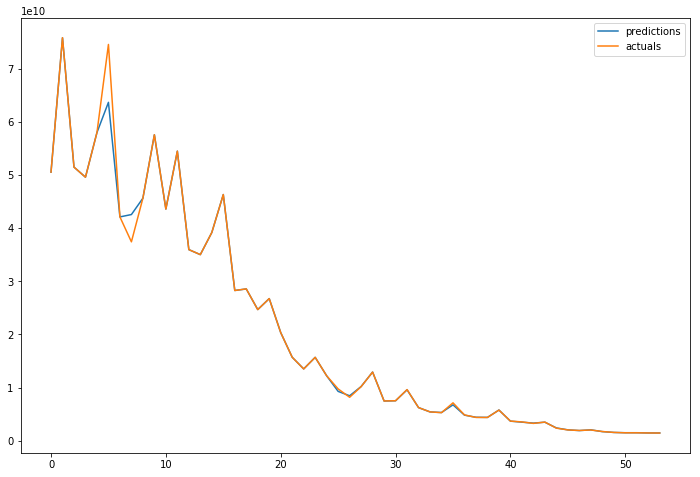

In [97]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

y_pred_list = list(y_pred)
pred_line, = matplotlib.pyplot.plot(range(len(dates)), y_pred_list, label='predictions')
actual_line, = matplotlib.pyplot.plot(range(len(dates)), y_test_aapl[:,0], label='actuals')
plt.legend(handles=[pred_line, actual_line])

In [98]:
#ANSWER TO THE QUESTION:
#Predicting first quarter of 2018 rather than the entire year, could extend this to test
#to rest of year when AAPL results come out in July, as we are predicting two quarters
#in advance
print("prediction: {0}, actual: {1}, 2018-03-31".format(y_pred_list[0], y_test_aapl[0,0]))

prediction: 50552655872.0, actual: 50557000000.0, 2018-03-31


In [99]:
#We appear to be overfitting to old data.  Let's just include the last 5 years for training:
rows_shuffled  = np.ndarray.copy(rows[:len(rows)/3])
random.shuffle(rows_shuffled)

rows_dropped_tickers = rows_shuffled[:,1:]
divide_index = len(rows_dropped_tickers)/6

test_arr = rows_dropped_tickers[:divide_index]

x_test = test_arr[:,:-1]
y_test = test_arr[:,-1:]

train_arr = rows_dropped_tickers[divide_index:]
x_train = train_arr[:,:-1]
y_train = train_arr[:,-1:]

model2 = XGBRegressor(max_depth=10, n_estimators=130, n_jobs=2, tree_method="hist")
model2.fit(x_train, y_train)

y_pred = model2.predict(x_test)
predictions = [value for value in y_pred]

results = list(zip(predictions, y_test))
accuracy = [math.fabs(float(r[0]) - float(r[1])) for r in results]

print("test average difference: " + str(sum(accuracy)/len(accuracy)))
#I hoped it would be lower but it will probably be higher

test acc: 77591265.24908632


In [47]:
#ANSWER TO THE QUESTION take two:
print("prediction: {0}, actual: {1}, 2018-03-31".format(y_pred_list[0], y_test_aapl[0,0]))

prediction: 53934895104.0, actual: 50557000000.0, 2018-03-31


In [100]:
#Is our 15 year model overfitting to particular stocks?  Particularly AAPL?
#Let's exclude AAPL:
#Apologies for code duplication.  I would make the second method below 
#pure if I had more time and reuse it

rows2 = np.array([], dtype=np.float).reshape(0, column_count)


def convert_row_to_floats(row):
    return [float(x) for x in row]

def create_rows_and_outputs_not_aapl(path):
    with open(path, "r") as myfile:
        global y_values
        global rows2
        s = myfile.read()

        data_x = s[(s.find("<pre>gap here\nbreak ") + 20):s.rfind(",\n</pre>")]

        two_quarters = data_x.split(", gap here\nbreak ")
        new_rows = [row.split(", break ") for row in two_quarters]

        full_rows1 = [row.split(", ") for row in new_rows[0]]
        full_rows2 = [row.split(", ") for row in new_rows[1]]

        aapl_1 = [i[1:] for i in full_rows1 if i[0] != "AAPL"]
        aapl_2 = [i[1:] for i in full_rows2 if i[0] != "AAPL"]

        float_rows1 = [convert_row_to_floats(row) for row in aapl_1]
        float_rows2 = [convert_row_to_floats(row) for row in aapl_2]

        rows2 = np.concatenate((rows2, float_rows1, float_rows2), axis=0)

[create_rows_and_outputs_not_aapl(p) for p in paths]
print("Non AAPL rows created only")

Non AAPL rows created only


In [101]:
rows_shuffled  = np.ndarray.copy(rows2)

random.shuffle(rows_shuffled)
rows_dropped_tickers = rows_shuffled[:,1:]

divide_index = len(rows_dropped_tickers)/6
test_arr = rows_dropped_tickers[:divide_index]

x_test = test_arr[:,:-1]
y_test = test_arr[:,-1:]

train_arr = rows_dropped_tickers[divide_index:]
x_train = train_arr[:,:-1]
y_train = train_arr[:,-1:]

In [106]:
model = XGBRegressor(max_depth=10, n_estimators=130, n_jobs=2, tree_method="hist")

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

predictions = [value for value in y_pred]

results = list(zip(predictions, y_test))

accuracy = [math.fabs(float(r[0]) - float(r[1])) for r in results]

print("test average difference: " + str((sum(accuracy)/len(accuracy))))

test average difference: 64509230.053963885


In [107]:
#Actual vs prediction for AAPL:
rows2 = np.array([], dtype=np.float).reshape(0, column_count)

def convert_row_to_floats(row):
    return [float(x) for x in row]

def create_rows_and_outputs_aapl(path):
    with open(path, "r") as myfile:
        global y_values
        global rows2
        s = myfile.read()

        data_x = s[(s.find("<pre>gap here\nbreak ") + 20):s.rfind(",\n</pre>")]

        two_quarters = data_x.split(", gap here\nbreak ")
        new_rows = [row.split(", break ") for row in two_quarters]

        full_rows1 = [row.split(", ") for row in new_rows[0]]
        full_rows2 = [row.split(", ") for row in new_rows[1]]

        aapl_1 = [i[1:] for i in full_rows1 if i[0] == "AAPL"]
        aapl_2 = [i[1:] for i in full_rows2 if i[0] == "AAPL"]

        float_rows1 = [convert_row_to_floats(row) for row in aapl_1]
        float_rows2 = [convert_row_to_floats(row) for row in aapl_2]

        rows2 = np.concatenate((rows2, float_rows1, float_rows2), axis=0)

[create_rows_and_outputs_aapl(p) for p in paths]
print("AAPL only rows created")

AAPL only rows created


(58445144000.0, 50557000000.0)
Populating the interactive namespace from numpy and matplotlib


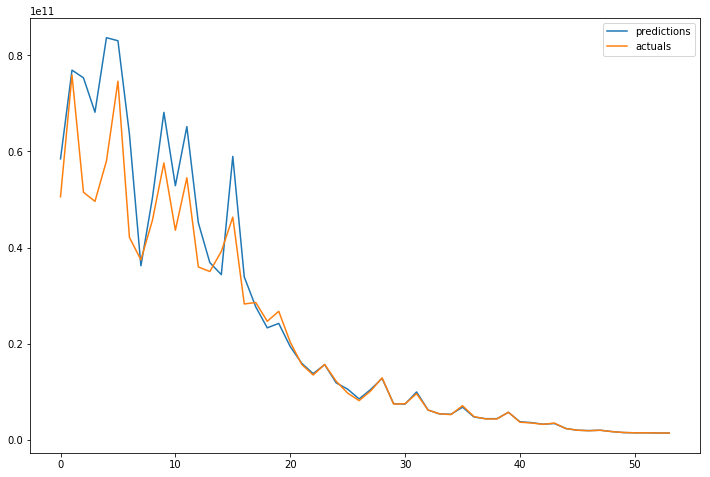

In [109]:
rows_aapl = rows2[:,1:]
y_test_aapl = rows_aapl[:,-1:]
x_test_aapl = rows_aapl[:,:-1]

y_pred = model.predict(x_test_aapl)
print(zip(y_pred, y_test_aapl[:,0])[0])

start_date = datetime.datetime.strptime("2017-09-30", "%Y-%m-%d")

dates = []

for i in range(54):
    dt = start_date
    dates.append(dt)
    dt = dt - dateutil.relativedelta.relativedelta(months=3)
    
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

y_pred_list = list(y_pred)
pred_line, = matplotlib.pyplot.plot(range(len(dates)), y_pred_list, label='predictions')
actual_line, = matplotlib.pyplot.plot(range(len(dates)), y_test_aapl[:,0], label='actuals')
plt.legend(handles=[pred_line, actual_line])

In [110]:
#That's even better!
#ANSWER TO THE QUESTION take three:
print("prediction: {0}, actual: {1}, 2018-03-31".format(y_pred_list[0], y_test_aapl[0,0]))
#Worse than before but a bit fairer.

prediction: 58445144064.0, actual: 50557000000.0, 2018-03-31


In [113]:
rfe = RFE(model, 1)
fit = rfe.fit(x_train, y_train)
top_1_n_features_model = fit.n_features_
top_1_n_support_model = fit.support_
top_1_n_ranking_model = fit.ranking_

In [114]:
top_1_n_ranking_model

array([ 37,  46, 174, 144, 162, 125, 193, 132, 194, 196, 149, 157, 186,
       204,  90, 183, 192, 128, 102, 112, 166, 159, 200, 187,  91, 190,
       205, 152, 146, 155, 131, 175, 252, 117, 136, 110,  92, 240,  85,
       244, 143, 178, 145, 115, 238, 239, 241, 281, 245, 247, 249, 158,
       256, 133, 264, 105, 269, 266, 270, 271, 165, 278, 185, 276, 180,
       228, 258, 260, 181, 177, 122,  95,  86,  89,  93, 126, 176,  81,
        99, 113,  79, 111, 124,  83, 170,  75, 191, 118, 119, 139, 100,
       161, 218, 129, 107, 173, 253, 109,  77, 138,  69,  73, 108,  84,
        98,  76, 171, 148, 291, 156, 167, 123, 106, 104, 164, 163,  80,
       257, 211, 234, 235,  96, 135, 272, 279, 140, 274, 189, 277,  88,
       184,  94, 101, 262,  97, 265, 141, 137, 230, 120, 182, 168, 284,
       179, 103, 292, 294, 296, 116, 263, 261, 160, 255, 251, 130, 237,
       233, 172, 231, 250, 207, 209, 121, 229, 210, 212, 134, 219, 220,
       223, 225, 226, 224, 243, 147, 232, 142, 208, 114, 259, 27

In [116]:
last_columns = ["quarter",
    "q1_debt",
    "q2_debt",
    "q3_debt",
    "q4_debt",
    "q5_debt",
    "q6_debt",
    "q7_debt",
    "q8_debt",
    "q1_gross_profit",
    "q2_gross_profit",
    "q3_gross_profit",
    "q4_gross_profit",
    "q5_gross_profit",
    "q6_gross_profit",
    "q7_gross_profit",
    "q8_gross_profit",
    "q1_operating_income",
    "q2_operating_income",
    "q3_operating_income",
    "q4_operating_income",
    "q5_operating_income",
    "q6_operating_income",
    "q7_operating_income",
    "q8_operating_income",
    "q1_operating_revenue",
    "q2_operating_revenue",
    "q3_operating_revenue",
    "q4_operating_revenue",
    "q5_operating_revenue",
    "q6_operating_revenue",
    "q7_operating_revenue",
    "q8_operating_revenue",
    "q1_current_ratio",
    "q2_current_ratio",
    "q3_current_ratio",
    "q4_current_ratio",
    "q5_current_ratio",
    "q6_current_ratio",
    "q7_current_ratio",
    "q8_current_ratio",
    "q1_financial_leverage",
    "q2_financial_leverage",
    "q3_financial_leverage",
    "q4_financial_leverage",
    "q5_financial_leverage",
    "q6_financial_leverage",
    "q7_financial_leverage",
    "q8_financial_leverage",
    "q1_revenue_growth",
    "q2_revenue_growth",
    "q3_revenue_growth",
    "q4_revenue_growth",
    "q5_revenue_growth",
    "q6_revenue_growth",
    "q7_revenue_growth",
    "q8_revenue_growth",
    "q1_roe",
    "q2_roe",
    "q3_roe",
    "q4_roe",
    "q5_roe",
    "q6_roe",
    "q7_roe",
    "q8_roe",
    "q1_market_cap",
    "q2_market_cap",
    "q3_market_cap",
    "q4_market_cap",
    "q5_market_cap",
    "q6_market_cap",
    "q7_market_cap",
    "q8_market_cap",
    "q1_total_revenue",
    "q2_total_revenue",
    "q3_total_revenue",
    "q4_total_revenue",
    "q5_total_revenue",
    "q6_total_revenue",
    "q7_total_revenue",
    "q8_total_revenue"]

In [118]:
ranks_of_last_columns = top_1_n_ranking_model[-len(last_columns):]

In [119]:
results = zip(last_columns, ranks_of_last_columns)
for res in results:
    print(res)

('quarter', 8)
('q1_debt', 3)
('q2_debt', 41)
('q3_debt', 49)
('q4_debt', 56)
('q5_debt', 57)
('q6_debt', 61)
('q7_debt', 65)
('q8_debt', 17)
('q1_gross_profit', 10)
('q2_gross_profit', 22)
('q3_gross_profit', 34)
('q4_gross_profit', 43)
('q5_gross_profit', 31)
('q6_gross_profit', 18)
('q7_gross_profit', 44)
('q8_gross_profit', 47)
('q1_operating_income', 295)
('q2_operating_income', 293)
('q3_operating_income', 290)
('q4_operating_income', 289)
('q5_operating_income', 288)
('q6_operating_income', 287)
('q7_operating_income', 286)
('q8_operating_income', 221)
('q1_operating_revenue', 42)
('q2_operating_revenue', 14)
('q3_operating_revenue', 59)
('q4_operating_revenue', 52)
('q5_operating_revenue', 24)
('q6_operating_revenue', 16)
('q7_operating_revenue', 30)
('q8_operating_revenue', 39)
('q1_current_ratio', 2)
('q2_current_ratio', 27)
('q3_current_ratio', 35)
('q4_current_ratio', 45)
('q5_current_ratio', 48)
('q6_current_ratio', 15)
('q7_current_ratio', 50)
('q8_current_ratio', 32)
('q

In [125]:
#which measurements had the highest average rank?
print("debt: " + str(sum(ranks_of_last_columns[1:9])))
print("gross_profit: " + str(sum(ranks_of_last_columns[9:17])))
print("operating_income: " + str(sum(ranks_of_last_columns[17:25])))
print("operating_revenue: " + str(sum(ranks_of_last_columns[25:33])))
print("current_ratio: " + str(sum(ranks_of_last_columns[33:41])))
print("financial_leverage: " + str(sum(ranks_of_last_columns[41:49])))
print("revenue_growth: " + str(sum(ranks_of_last_columns[49:57])))
print("roe: " + str(sum(ranks_of_last_columns[57:65])))
print("market_cap: " + str(sum(ranks_of_last_columns[65:73])))
print("total_revenue: " + str(sum(ranks_of_last_columns[73:81])))

debt: 349
gross_profit: 249
operating_income: 2249
operating_revenue: 276
current_ratio: 254
financial_leverage: 355
revenue_growth: 90
roe: 208
market_cap: 492
total_revenue: 516


In [130]:
#My guess is that revenue_growth and the quarter we're in is heavily driving our model
#Also Financial Leverage seems strange to be ranked so highly
#Let's remove these features, retrain, and see what the model does:


#remove quarter and revenue growth
x_train_new = np.delete(x_train, [215, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271], 1)
x_test_new = np.delete(x_test, [215, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271], 1)


In [131]:
x_train_new.shape

(66555, 279)

In [132]:
model3 = XGBRegressor(max_depth=10, n_estimators=130, n_jobs=2, tree_method="hist")
model3.fit(x_train_new, y_train)

y_pred = model3.predict(x_test_new)
predictions = [value for value in y_pred]

results = list(zip(predictions, y_test))
accuracy = [math.fabs(float(r[0]) - float(r[1])) for r in results]

print("test average difference: " + str(sum(accuracy)/len(accuracy)))
#Not so different to previous model.

test average difference: 68919991.31540643
